# Entity Embeddding Using Fastai

## Installing Library

In [ ]:
!pip install -U fastai

     |████████████████████████████████| 189 kB 11.7 MB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


## Class

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import altair as alt
from sklearn.decomposition import PCA
from fastai.tabular.all import *


class EntEmbedding:
    def __init__(self, df, target):
        """
        Parameters
        ----------
        df : dataframe
           features and target you want to use
        target : str
           column name of your target
        """
        self.df = df
        self.target = target

    def cat_split(self, max_card=100):

        self.cont_names, self.cat_names = cont_cat_split(
            self.df, max_card=max_card, dep_var=self.target
        )
        self.procs_nn = [Categorify, FillMissing, Normalize]

        print(
            len(self.cont_names),
            "Continous Features:",
            self.cont_names,
            "\n",
            len(self.cat_names),
            "Categorical Features:",
            self.cat_names,
        )

    def find_alpha(
        self, regression=True, batch_size=1024, layer_size=[500, 250], metrics=rmse
    ):
        """
        max_card : int
              if nunique > max_card value, it will be identified as continous, otherwis caregorical
        batch_size : int
              batch size used during training
        layer_size : list
              layer widths with to layers
        metrics : function
              uses sklearn metric names

        """
        if regression:
            self.df.loc[:, self.target] = self.df.loc[:, self.target].astype(np.float32)
            to_nn = TabularPandas(
                self.df,
                self.procs_nn,
                self.cat_names,
                self.cont_names,
                splits=RandomSplitter()(range_of(self.df)),
                y_names=self.target,
            )
            self.dls = to_nn.dataloaders(batch_size)
            y = to_nn.train.y
            self.learn = tabular_learner(
                self.dls,
                layers=layer_size,
                y_range=(y.min(), y.max()),
                n_out=1,
                metrics=metrics,
            )
        else:

            to_nn = TabularPandas(
                self.df,
                self.procs_nn,
                self.cat_names,
                self.cont_names,
                splits=RandomSplitter()(range_of(self.df)),
                y_names=self.target,
                y_block=CategoryBlock(),
            )
            self.dls = to_nn.dataloaders(batch_size)

            self.learn = tabular_learner(self.dls, layers=layer_size, metrics=metrics)
        self.alpha = self.learn.lr_find()
        print(self.alpha)

    def fit(self, epochs=50, alpha=1e-3):
        """
        epochs : int
           number of epochs model will be trained during fit
        alpha : int
           learning rate. preferrably you should set this parameter to the value returned by .find_alpha() method
        """
        self.learn.fit_one_cycle(n_epoch=epochs, lr_max=alpha)

    def embed_features(self, learner, xs, variable):
        # parameters for embed_features(model.learn, model.dls.train.xs, 'column_you_want_visualization_for')
        xs = xs.copy()
        self.var = variable
        new = []
        for i, feature in enumerate(learner.dls.cat_names):
            emb = learner.model.embeds[i]
            new_feat = pd.DataFrame(
                emb(tensor(xs[feature], dtype=torch.int64)),
                index=xs.index,
                columns=[f"{feature}_{j}" for j in range(emb.embedding_dim)],
            )
            new.append(new_feat)
            ix = learner.dls.cat_names.index(variable)
            self.var_vals = list(
                self.df[variable].astype("category").cat.categories.values
            )
            emb_mx = to_np(next(learner.model.embeds[ix].parameters()))
            self.X_emb = PCA(n_components=2).fit_transform(emb_mx)
        new = pd.concat(new, axis=1)

        return new

    def visualize(self):
        emb_df = pd.DataFrame(self.X_emb[1:], columns=["Dim1", "Dim2"])
        emb_df[self.var] = np.array(self.var_vals)
        points = (
            alt.Chart(emb_df)
            .mark_circle(size=60)
            .encode(x="Dim1", y="Dim2", tooltip=[self.var])
        )

        text = points.mark_text(align="left", baseline="middle", dx=7).encode(
            text=self.var
        )

        graph = points + text

        return graph


## Classification

In [ ]:
df = pd.read_csv('Credit Card Defaulter Prediction.csv')

FileNotFoundError: ignored

In [ ]:
df.head()

In [ ]:
df.columns.nunique()

In [ ]:
model = EntEmbedding(df, 'default ')

In [ ]:
model.cat_split()

In [ ]:
model.find_alpha(regression=False, batch_size=512, metrics=[accuracy, error_rate, Recall(), Precision()])

In [ ]:
model.fit(10, 0.0002754228771664202)

In [ ]:
interpret = ClassificationInterpretation.from_learner(model.learn)
interpret.plot_confusion_matrix()

In [ ]:
model.embed_features(model.learn, model.dls.train.xs, 'SEX')

In [ ]:
model.visualize()

## Regression

In [ ]:
df_reg = pd.read_csv('https://raw.githubusercontent.com/wblakecannon/ames/master/data/housing.csv')

In [ ]:
df_reg.head()

,Unnamed: 0,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [ ]:
model = EntEmbedding(df_reg, 'SalePrice')

In [ ]:
df_reg = df_reg[['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Sale Condition', 'Neighborhood', 'SalePrice']]

In [ ]:
df_reg.nunique()

MS SubClass         16
MS Zoning            7
Lot Frontage       128
Lot Area          1960
Street               2
Sale Condition       6
Neighborhood        28
SalePrice         1032
dtype: int64

In [ ]:
model.cat_split()

23 Continous Features: ['Unnamed: 0', 'Order', 'PID', 'Lot Frontage', 'Lot Area', 'Year Built', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', 'Screen Porch'] 
 59 Categorical Features: ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Low Qual Fin SF', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 

SuggestedLRs(valley=0.0005754399462603033)


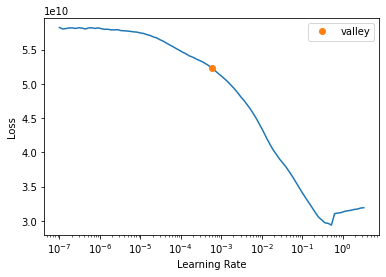

In [ ]:
model.find_alpha(regression=True)

In [ ]:
model.fit(20,0.0005754399462603033)

epoch,train_loss,valid_loss,_rmse,time
0,57656987648.000000,51068383232.000000,225983.140625,00:00
1,55447134208.000000,51156332544.000000,226177.656250,00:00
2,53153181696.000000,51202928640.000000,226280.640625,00:00
3,51632603136.000000,51503198208.000000,226943.156250,00:00
4,50340921344.000000,51226071040.000000,226331.765625,00:00
5,48730443776.000000,50297511936.000000,224271.062500,00:00
6,47193088000.000000,49367638016.000000,222188.296875,00:00
7,45647585280.000000,48045342720.000000,219192.484375,00:00
8,44153425920.000000,46728249344.000000,216167.171875,00:00
9,42737008640.000000,45891555328.000000,214223.140625,00:00


In [ ]:
model.embed_features(model.learn, model.dls.train.xs, 'Neighborhood')

,MS SubClass_0,MS SubClass_1,MS SubClass_2,MS SubClass_3,MS SubClass_4,MS SubClass_5,MS SubClass_6,MS SubClass_7,MS Zoning_0,MS Zoning_1,...,Bsmt Half Bath_na_2,Garage Yr Blt_na_0,Garage Yr Blt_na_1,Garage Yr Blt_na_2,Garage Cars_na_0,Garage Cars_na_1,Garage Cars_na_2,Garage Area_na_0,Garage Area_na_1,Garage Area_na_2
2088,0.000737,0.016910,-0.016846,0.001906,-0.004813,0.008813,-0.010587,0.007938,-0.001021,-0.012705,...,0.019522,-0.012013,0.016442,0.006943,0.005348,0.014824,-0.002991,0.011816,-0.000359,-0.016776
1328,0.003960,-0.009062,-0.008859,0.008014,0.005604,-0.004458,0.008190,-0.008829,-0.007081,0.008147,...,0.019522,-0.012013,0.016442,0.006943,0.005348,0.014824,-0.002991,0.011816,-0.000359,-0.016776
321,0.000737,0.016910,-0.016846,0.001906,-0.004813,0.008813,-0.010587,0.007938,-0.001021,-0.012705,...,0.019522,-0.012013,0.016442,0.006943,0.005348,0.014824,-0.002991,0.011816,-0.000359,-0.016776
2409,0.025218,0.000735,0.008441,-0.009280,0.004846,0.015179,0.005294,0.003850,-0.001021,-0.012705,...,0.019522,-0.012013,0.016442,0.006943,0.005348,0.014824,-0.002991,0.011816,-0.000359,-0.016776
1021,0.000737,0.016910,-0.016846,0.001906,-0.004813,0.008813,-0.010587,0.007938,-0.001021,-0.012705,...,0.019522,-0.012013,0.016442,0.006943,0.005348,0.014824,-0.002991,0.011816,-0.000359,-0.016776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.004144,-0.002536,-0.016628,-0.006252,0.011916,-0.017503,0.003546,-0.000570,0.002582,-0.007199,...,0.019522,-0.012013,0.016442,0.006943,0.005348,0.014824,-0.002991,0.011816,-0.000359,-0.016776
2791,0.004144,-0.002536,-0.016628,-0.006252,0.011916,-0.017503,0.003546,-0.000570,-0.001021,-0.012705,...,0.019522,-0.012013,0.016442,0.006943,0.005348,0.014824,-0.002991,0.011816,-0.000359,-0.016776
1291,-0.010450,-0.002217,-0.004010,0.000741,-0.006435,-0.005949,0.012059,0.008122,-0.007081,0.008147,...,0.019522,0.006587,-0.003163,-0.001744,0.005348,0.014824,-0.002991,0.011816,-0.000359,-0.016776
2290,0.005643,-0.002871,-0.006317,-0.001077,-0.007547,-0.003690,0.014745,0.009203,-0.007081,0.008147,...,0.019522,-0.012013,0.016442,0.006943,0.005348,0.014824,-0.002991,0.011816,-0.000359,-0.016776


In [ ]:
model.visualize()

alt.LayerChart(...)